# Creating Bangalore Grid

Here, we will create a hexagonal grid of uniform size to cover the Bangalore city area. We will use data from the [Karanataka Government website](https://kgis.ksrsac.in/kgis/downloads.aspx)  (converted to GeoJSON [here](https://ogre.adc4gis.com/)), which has been retrieved and stored in the data folder.

In [6]:
import numpy as np
import pandas as pd

from geopy import Nominatim

from ratelimiter import RateLimiter
from tqdm.notebook import tqdm
from diskcache import Cache

import geojson
import geopandas as gpd
from shapely.geometry.polygon import orient

import folium
import h3

In [7]:
DRY_RUN = True

#! IMPORTANT NOTE:
#! Setting a flag here to ensure that files are not overwritten unless necessary.
#! Changing hex coordinates in the GeoJSON file will affect all future operations, and require more API calls.
#! Set this value to False only if the files need to be regenerated.

In [8]:
# Creating a geocoder with specific user agent as required by Nominatim
geocoder = Nominatim(user_agent = 'coursera_capstone')

# Rate limiter to adhere to Nominatim's 1 request/second limit
limiter = RateLimiter(max_calls = 1, period = 1)

# Cache Path to store Nominatum responses
nom_cache = '../data/cache/nominatim'

## Obtain City Boundaries

We will consider the entire Bangalore (Urban) district area designated by the Karnataka State Government.

**Data Source:** District Boundaries from the [Karnataka-GIS website](https://kgis.ksrsac.in/kgis/downloads.aspx).

In [9]:
# Read the shapefile data into a GeoDataFrame
shapefile = 'zip://../data/karnataka_districts_shapefile.zip'
df_districts = gpd.read_file(shapefile)

df_districts = df_districts.to_crs("EPSG:4326") # Converting Coordinate Reference System to EPSG:4326
df_districts.crs # Check Coordinate Reference System

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
df_districts.head()

,OBJECTID,KGISDistri,KGISDist_1,BhuCodeDis,created_us,created_da,last_edite,last_edi_1,SHAPE_STAr,SHAPE_STLe,geometry
0,1,01,Belagavi,01,None,None,SA,2020-11-10,1.339922e+10,1.142854e+06,"MULTIPOLYGON (((75.04121 16.43896, 75.04080 16..."
1,2,02,Bagalkot,02,None,None,SA,2020-11-07,6.561945e+09,6.685642e+05,"POLYGON ((75.74371 15.81296, 75.74226 15.81299..."
2,3,03,Vijayapura,03,None,None,None,None,1.050303e+10,7.032936e+05,"POLYGON ((76.27367 16.15207, 76.26983 16.15212..."
3,4,04,Kalburgi,04,None,None,SA,2020-11-09,1.097529e+10,9.164460e+05,"MULTIPOLYGON (((76.70341 17.69329, 76.70332 17..."
4,5,05,Bidar,05,None,None,None,None,5.453885e+09,5.747318e+05,"MULTIPOLYGON (((77.27821 18.45341, 77.27548 18..."


In [11]:
# We need to keep only the Bengaluru (Urban) row
df_blr = df_districts[
    df_districts['KGISDist_1'].str.contains('Bengaluru')
    & df_districts['KGISDist_1'].str.contains('Urban')
    ].reset_index(drop=True)

df_blr.head()

,OBJECTID,KGISDistri,KGISDist_1,BhuCodeDis,created_us,created_da,last_edite,last_edi_1,SHAPE_STAr,SHAPE_STLe,geometry
0,20,20,Bengaluru (Urban),20,None,None,SA,2020-11-10,2.195802e+09,344907.278899,"MULTIPOLYGON (((77.55148 12.79390, 77.55141 12..."


Total Area: 0.182710

Polygon 0 Area: 0.000008
Polygon 0 Ratio: 0.000042


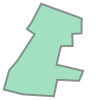


Polygon 1 Area: 0.182702
Polygon 1 Ratio: 0.999958


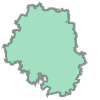

In [12]:
multipoly = df_blr.geometry[0]
polygons = list(multipoly) # Convert to a list of polygons
print('Total Area: {:2f}'.format(multipoly.area))
for i in range(len(polygons)):
    print('\nPolygon {} Area: {:2f}'.format(i,polygons[i].area))
    print('Polygon {} Ratio: {:2f}'.format(i,polygons[i].area/multipoly.area)) # What proportion of area does this polygon cover?
    display(polygons[i])

We can safely ignore the first polygon in this case, given its negligible size. Lets update the GeoDataFrame with this new Polygon as the geometry.

In [13]:
df_blr.geometry[0] = orient(polygons[1]) # Orient polygon correctly (right hand rule) and assign geometry
df_blr = df_blr[['KGISDistri', 'KGISDist_1', 'geometry']]
df_blr = df_blr.rename(columns = {'KGISDistri': 'District_ID', 'KGISDist_1': 'District_Name'})
df_blr.head()

,District_ID,District_Name,geometry
0,20,Bengaluru (Urban),"POLYGON ((77.68965 12.65849, 77.69050 12.65924..."


In [14]:
# Save this file to GeoJSON
#! Only if Dry Run is disabled
if not DRY_RUN:
    df_blr.to_file('../data/bengaluru_urban.geojson', driver = 'GeoJSON')

### Plotting Boundaries

We plot the geoJSON file created to a map to see the area that will be studied in this project.

In [15]:
with open('../data/bengaluru_urban.geojson') as file:
    geodata = geojson.load(file)

In [16]:
# Obtain centre coordinates for map

map_centre_address = 'Bengaluru, Karnataka, India'

with Cache(nom_cache) as cache:
    map_centre = cache.get(map_centre_address) # Check for cached location before querying

    while not map_centre:
        with limiter:
            map_centre = geocoder.geocode(map_centre_address)
            cache.set(map_centre_address, map_centre) # Save to cache

# Plot map
m = folium.Map((map_centre.latitude, map_centre.longitude), zoom_start=10)
folium.Choropleth(geodata, name='geoJSON').add_to(m)

m # Display Map

## Creating Hexagonal grid

We wil use the [H3](https://github.com/uber/h3) geospatial system developed by Uber to create a grid of hex tiles covering the area described by our geoJSON file.

**Note:** Below is the table of possible resolutions, taken from [link](https://h3geo.org/docs/core-library/restable).

| H3 Resolution | Average Hexagon Area (km<sup>2</sup>) | Average Hexagon Edge Length (km) | Number of unique indexes |
|---------------|----------------------------|----------------------------------|--------------------------|
| 0             | 4,250,546.8477000          | 1,107.712591000                  | 122                      |
| 1             | 607,220.9782429            | 418.676005500                    | 842                      |
| 2             | 86,745.8540347             | 158.244655800                    | 5,882                    |
| 3             | 12,392.2648621             | 59.810857940                     | 41,162                   |
| 4             | 1,770.3235517              | 22.606379400                     | 288,122                  |
| 5             | 252.9033645                | 8.544408276                      | 2,016,842                |
| 6             | 36.1290521                 | 3.229482772                      | 14,117,882               |
| 7             | 5.1612932                  | 1.220629759                      | 98,825,162               |
| 8             | 0.7373276                  | 0.461354684                      | 691,776,122              |
| 9             | 0.1053325                  | 0.174375668                      | 4,842,432,842            |
| 10            | 0.0150475                  | 0.065907807                      | 33,897,029,882           |
| 11            | 0.0021496                  | 0.024910561                      | 237,279,209,162          |
| 12            | 0.0003071                  | 0.009415526                      | 1,660,954,464,122        |
| 13            | 0.0000439                  | 0.003559893                      | 11,626,681,248,842       |
| 14            | 0.0000063                  | 0.001348575                      | 81,386,768,741,882       |
| 15            | 0.0000009                  | 0.000509713                      | 569,707,381,193,162      |

In [17]:
# The current h3 python package function supports only a dict containing a Polygon, so we need to extract this from our file
file_dict = eval(geojson.dumps(geodata))
poly = file_dict['features'][0]['geometry']

In [18]:
hex_res = 8 # See list of resolutions
hexagons = list(h3.polyfill(poly, hex_res, geo_json_conformant=True))
print('{} Hexagon Grid generated.'.format(len(hexagons)))

2904 Hexagon Grid generated.


In [19]:
features_list = []

for hexagon in hexagons:
    hex_coords = list(h3.h3_to_geo_boundary(hexagon, geo_json = True))
    
    feature = geojson.Feature(
        geometry = geojson.Polygon([hex_coords]),
        id = hexagon,
        properties = {
            "centre_lat": h3.h3_to_geo(hexagon)[0],
            "centre_lng": h3.h3_to_geo(hexagon)[1],
            "resolution": hex_res,
            },
    )
    features_list.append(feature)

hexmap = geojson.FeatureCollection(features_list)

## Plotting the grid

Check the grid before saving it.

In [20]:
# Plot map
m = folium.Map((map_centre.latitude, map_centre.longitude), zoom_start=10)

# Draw Bangalore boundary area
folium.Choropleth(
    geodata,
    name='boundary',
    line_color = 'black',
    line_opacity = 0.8,
    line_weight = 3,
    fill_color = 'blue',
    fill_opacity = 0.0,
).add_to(m)

# Draw hexes
folium.Choropleth(
    hexmap,
    name='hex-grid',
    line_color = 'blue',
    line_opacity = 0.9,
    line_weight = 1,
    fill_color = 'blue',
    fill_opacity = 0.2,
).add_to(m)

m # Display map

In [21]:
# Save file to GeoJSON
#! Only if Dry Run is disabled
if not DRY_RUN:
    with open('../data/bangalore_hex_grid.geojson', 'w') as outfile:
        geojson.dump(hexmap, outfile)